# Fragment Linking with DeLinker

The purpose of this notebook is to demonstrate a simple, automated, end-to-end workflow for using DeLinker.

In this notebook, we will explore how DeLinker can be used to perform fragment linking. We will use two of the fragments from the recent Diamond Light Source XChem fragment screen from Diamond Light Source against the SARS-CoV-2 main protease (MPro) ([link](https://www.diamond.ac.uk/covid-19/for-scientists/Main-protease-structure-and-XChem.html)).

Please note: we make no claims about the suitability of the generated molecules in this example, or even if the fragments chosen are sensible to link together.

Any questions, comments or feedback, please email imrie@stats.ox.ac.uk

## Imports

In [1]:
import sys
sys.path.append("../")
sys.path.append("../analysis/")

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import MolStandardize

import numpy as np

from itertools import product
from joblib import Parallel, delayed
import re
from collections import defaultdict

from IPython.display import clear_output
IPythonConsole.ipython_useSVG = True

from DeLinker_test import DenseGGNNChemModel
import frag_utils
import rdkit_conf_parallel
from data.prepare_data import read_file, preprocess
import example_utils

## Basic settings

In [3]:
# How many cores for multiprocessing
n_cores = 4
# Whether to use GPU for generating molecules with DeLinker
use_gpu = False

## Load fragment hits and design example

We have chosen to link together two of the non-covalent fragment hits, 0678 and 0946. We have made a couple of minor modifications to the fragments before loading them here. In particular, we have removed the cyclohexane from 0678 and the bromine from 0946.

Let's load these and take a look at the structures.

In [4]:
frag_1_path = './Mpro-x0946_ligand_no_Br.sdf'
frag_2_path = './Mpro-x0678_ligand_no_cyclohexane.sdf'

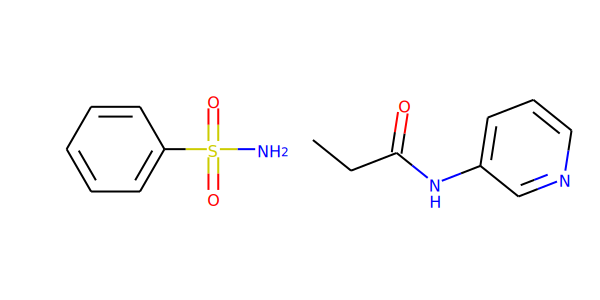

In [5]:
frag_1_sdf = Chem.SDMolSupplier(frag_1_path)
frag_1_smi = Chem.MolToSmiles(frag_1_sdf[0])

frag_2_sdf = Chem.SDMolSupplier(frag_2_path)
frag_2_smi = Chem.MolToSmiles(frag_2_sdf[0])

img = Draw.MolsToGridImage([Chem.MolFromSmiles(frag_1_smi), Chem.MolFromSmiles(frag_2_smi)], molsPerRow=2, subImgSize=(300, 300))
img

We'll now preprocess these into a format where they can be linked with DeLinker.

To do so, we'll need to combine the two fragments into one RDKit molecule object and add exit vectors to each of the fragments.

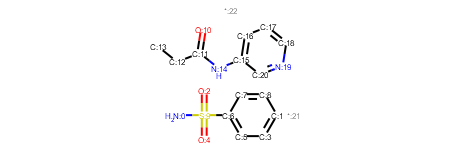

In [6]:
combo_no_exit = Chem.CombineMols(frag_1_sdf[0],frag_2_sdf[0])
combo = Chem.CombineMols(combo_no_exit, Chem.MolFromSmiles("*.*"))
combo_2d = Chem.Mol(combo)
_ = AllChem.Compute2DCoords(combo_2d)
example_utils.mol_with_atom_index(combo_2d)

We need to select which atoms we want to join the exit vectors to. Let's do this, and then view the new molecule.

In [7]:
atom_idx_1 = 1
atom_idx_2 = 13

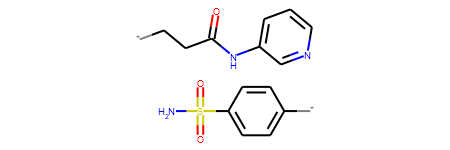

In [8]:
edcombo = Chem.EditableMol(combo)
num_heavy_atoms = combo.GetNumHeavyAtoms()
edcombo.AddBond(num_heavy_atoms, atom_idx_1, order=Chem.rdchem.BondType.SINGLE)
edcombo.AddBond(num_heavy_atoms+1, atom_idx_2, order=Chem.rdchem.BondType.SINGLE)
editedcombo = edcombo.GetMol()
_ = AllChem.Compute2DCoords(editedcombo)
Chem.SanitizeMol(editedcombo)
editedcombo

Finally, we need to determine the direction for the exit vectors. This can be done manually, or can be automated using the below constrained conformer generation code. This determines a sensible direction for the exit vector, without altering the conformation of the rest of the fragments. 

In [9]:
mol_to_link = edcombo.GetMol()
Chem.SanitizeMol(mol_to_link)

# Convert exit vectors to carbons for conformer generation
du = Chem.MolFromSmiles('*')
mol_to_link_carbon = AllChem.ReplaceSubstructs(mol_to_link,du,Chem.MolFromSmiles('C'),True)[0]
Chem.SanitizeMol(mol_to_link_carbon)
# Generate conformer
mol_to_link_carbon = Chem.AddHs(mol_to_link_carbon)
AllChem.ConstrainedEmbed(mol_to_link_carbon, combo_no_exit, randomseed=42)
mol_to_link_carbon = Chem.RemoveHs(mol_to_link_carbon)

In [10]:
# Add this conformer to the two unlinked fragments
conf = mol_to_link.GetConformer()
ref_conf = mol_to_link_carbon.GetConformer()
for i in range(mol_to_link_carbon.GetNumAtoms()):
    pos = list(ref_conf.GetAtomPosition(i))
    conf.SetAtomPosition(i, pos)
conf.SetId(0)
_ = mol_to_link.AddConformer(conf)

Let's view the 3D conformation to check exit vectors look sensbile.

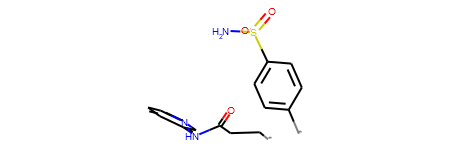

In [11]:
mol_to_link

## Prepare example as input data

We now need to calculate the structure information and preprocess this example into the form required by DeLinker.

In [12]:
# Get distance and angle between fragments
dist, ang = frag_utils.compute_distance_and_angle(mol_to_link, "", Chem.MolToSmiles(mol_to_link))
Chem.MolToSmiles(mol_to_link), dist, ang

('*CCC(=O)Nc1cccnc1.*c1ccc(S(N)(=O)=O)cc1',
 1.924858977390073,
 1.353467883637697)

In [13]:
# Write data to file
data_path = "./fragments_test_data.txt"
with open(data_path, 'w') as f:
    f.write("%s %s %s" % (Chem.MolToSmiles(mol_to_link), dist, ang))

In [14]:
raw_data = read_file(data_path)
preprocess(raw_data, "zinc", "fragments_test", True)

Finished reading: 1 / 1
Parsing smiles as graphs.
Processed: 1 / 1
Saving data
Length raw data: 	1
Length processed data: 	1


## Load DeLinker model and generate new molecules

Let's now setup and generate molecules with DeLinker. The below setting with generate 50 molecules for each length of linker from two to six atoms inclusively.

In [15]:
import os
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [16]:
# Arguments for DeLinker
args = defaultdict(None)
args['--dataset'] = 'zinc'
args['--config'] = '{"generation": true, \
                     "batch_size": 1, \
                     "number_of_generation_per_valid": 50, \
                     "min_atoms": 2, "max_atoms": 6, \
                     "train_file": "molecules_fragments_test.json", \
                     "valid_file": "molecules_fragments_test.json", \
                     "output_name": "DeLinker_example_generation.smi"}'
args['--freeze-graph-model'] = False
args['--restore'] = '../models/pretrained_DeLinker_model.pickle'

In [18]:
# Setup model and generate molecules
model = DenseGGNNChemModel(args)
model.train()
# Free up some memory
model = ''

Run 2020-04-08-12-19-37_23488 starting with following parameters:
{"task_sample_ratios": {}, "use_edge_bias": true, "clamp_gradient_norm": 1.0, "out_layer_dropout_keep_prob": 1.0, "tie_fwd_bkwd": true, "random_seed": 0, "batch_size": 1, "prior_learning_rate": 0.05, "stop_criterion": 0.01, "num_epochs": 10, "epoch_to_generate": 10, "number_of_generation_per_valid": 50, "maximum_distance": 50, "use_argmax_generation": false, "residual_connection_on": true, "residual_connections": {"2": [0], "4": [0, 2], "6": [0, 2, 4], "8": [0, 2, 4, 6], "10": [0, 2, 4, 6, 8], "12": [0, 2, 4, 6, 8, 10], "14": [0, 2, 4, 6, 8, 10, 12]}, "num_timesteps": 7, "hidden_size": 32, "encoding_size": 4, "kl_trade_off_lambda": 0.3, "learning_rate": 0.001, "graph_state_dropout_keep_prob": 1, "compensate_num": 0, "train_file": "molecules_fragments_test.json", "valid_file": "molecules_fragments_test.json", "try_different_starting": true, "num_different_starting": 1, "generation": true, "use_graph": true, "label_one_hot

## Assess generated molecules

Let's calculate some 2D and 3D properties of the generated molecules. We follow the same procedure to filter/score the molecules as described in our paper describing DeLinker.

In [19]:
# Load molecules
generated_smiles = frag_utils.read_triples_file("./DeLinker_example_generation.smi")

in_mols = [smi[1] for smi in generated_smiles]
frag_mols = [smi[0] for smi in generated_smiles]
gen_mols = [smi[2] for smi in generated_smiles]

du = Chem.MolFromSmiles('*')
clean_frags = [Chem.MolToSmiles(Chem.RemoveHs(AllChem.ReplaceSubstructs(Chem.MolFromSmiles(smi),du,Chem.MolFromSmiles('[H]'),True)[0])) for smi in frag_mols]

clear_output(wait=True)
print("Done")

Done


### 2D analysis

In [20]:
# Check valid
results = []
for in_mol, frag_mol, gen_mol, clean_frag in zip(in_mols, frag_mols, gen_mols, clean_frags):
    if len(Chem.MolFromSmiles(gen_mol).GetSubstructMatch(Chem.MolFromSmiles(clean_frag)))>0:
        results.append([in_mol, frag_mol, gen_mol, clean_frag])

print("Number of generated SMILES: \t%d" % len(generated_smiles))
print("Number of valid SMILES: \t%d" % len(results))
print("%% Valid: \t\t\t%.2f%%" % (len(results)/len(generated_smiles)*100))

Number of generated SMILES: 	250
Number of valid SMILES: 	247
% Valid: 			98.80%


In [21]:
# Determine linkers of generated molecules
linkers = Parallel(n_jobs=n_cores)(delayed(frag_utils.get_linker)(Chem.MolFromSmiles(m[2]), Chem.MolFromSmiles(m[3]), m[1]) \
                                   for m in results)
# Standardise linkers
for i, linker in enumerate(linkers):
    if linker == "":
        continue
    linker = Chem.MolFromSmiles(re.sub('[0-9]+\*', '*', linker))
    Chem.rdmolops.RemoveStereochemistry(linker)
    linkers[i] = MolStandardize.canonicalize_tautomer_smiles(Chem.MolToSmiles(linker))
# Update results
for i in range(len(results)):
    results[i].append(linkers[i])
    
clear_output(wait=True)
print("Done")

Done


In [22]:
# Create dictionary of results
results_dict = {}
for res in results:
    if res[0]+'.'+res[1] in results_dict: # Unique identifier - starting fragments and original molecule
        results_dict[res[0]+'.'+res[1]].append(tuple(res))
    else:
        results_dict[res[0]+'.'+res[1]] = [tuple(res)]

In [23]:
# Check uniqueness
print("Unique molecules: %.2f%%" % (frag_utils.unique(results_dict.values())*100))

Unique molecules: 43.72%


In [24]:
# Check if molecules pass 2D filters 
filters_2d = frag_utils.calc_filters_2d_dataset(results, pains_smarts_loc="../analysis/wehi_pains.csv", n_cores=n_cores)

results_filt = []
for res, filt in zip(results, filters_2d):
    if filt[0] and filt[1] and filt[2]:
        results_filt.append(res)
        
clear_output(wait=True)        
print("Pass all 2D filters: \t\t\t\t%.2f%%" % (len(results_filt)/len(results)*100))
print("Valid and pass all 2D filters: \t\t\t%.2f%%" % (len(results_filt)/len(generated_smiles)*100))
print("Pass synthetic accessibility (SA) filter: \t%.2f%%" % (len([f for f in filters_2d if f[0]])/len(filters_2d)*100))
print("Pass ring aromaticity filter: \t\t\t%.2f%%" % (len([f for f in filters_2d if f[1]])/len(filters_2d)*100))
print("Pass SA and ring filters: \t\t\t%.2f%%" % (len([f for f in filters_2d if f[0] and f[1]])/len(filters_2d)*100))
print("Pass PAINS filters: \t\t\t\t%.2f%%" % (len([f for f in filters_2d if f[2]])/len(filters_2d)*100))

Pass all 2D filters: 				92.71%
Valid and pass all 2D filters: 			91.60%
Pass synthetic accessibility (SA) filter: 	94.74%
Pass ring aromaticity filter: 			97.57%
Pass SA and ring filters: 			92.71%
Pass PAINS filters: 				100.00%


In [25]:
# Get unique molecules
print("Number molecules passing 2D filters:\t\t%d" % len(results_filt))
results_filt_unique = example_utils.unique_mols(results_filt)
print("Number unique molecules passing 2D filters:\t%d" % len(results_filt_unique))

Number molecules passing 2D filters:		229
Number unique molecules passing 2D filters:	92


### 3D analysis

In [26]:
# Generate conformers
_ = rdkit_conf_parallel.gen_confs([res[2] for res in results_filt_unique], "./DeLinker_generated_mols_unique.sdf",
                                  smi_frags=[res[1] for res in results_filt_unique], numcores=n_cores, jpsettings=True)
clear_output(wait=True)
print("Done")

Done


In [27]:
# Load conformers
gen_sdfs = Chem.SDMolSupplier("./DeLinker_generated_mols_unique.sdf")
ref_mol = Chem.Mol(combo_no_exit)

In [28]:
# Get list of starting fragments and original molecules
used = set([])
ref_identifiers = [(res[1], res[0]) for res in results_filt if res[1]+'.'+res[0] not in used and (used.add(res[1]+'.'+res[0]) or True)]

# Get indices of compounds in SD file
start_stop_idxs = []
start = 0
errors = 0

curr_st_pt = ""
for count, gen_mol in enumerate(gen_sdfs):
    try:
        # Check if seen this ligand before
        if gen_mol.GetProp("_Model") == str(0):
            stop = count
            if count != 0:
                start_stop_idxs.append((start, stop))
            start = int(stop) # deep copy
            curr_st_pt = gen_mol.GetProp("_StartingPoint")
    except:
        errors += 1
        continue

# Add last
start_stop_idxs.append((start, len(gen_sdfs)))

In [29]:
# Calculate SC_RDKit fragments scores
names_frags = []
best_scores_frags = []
idx_best_poses_frags = []
names_frags_start_pts = []

with Parallel(n_jobs=n_cores, backend='multiprocessing') as parallel:
    for i in range(-(-len(start_stop_idxs)//n_cores)):
        jobs = []
        for core in range(n_cores):
            if i*n_cores+core < len(start_stop_idxs):
                start, stop = start_stop_idxs[i*n_cores+core]
                frag_smi = gen_sdfs[start].GetProp("_StartingPoint")
                # Prepare jobs
                gen_mols = [(Chem.Mol(gen_sdfs[idx]), Chem.Mol(ref_mol), str(frag_smi)) for idx in range(start, stop) if gen_sdfs[idx] is not None] # Test addition
                jobs.append(gen_mols)

        # Get SC_RDKit scores
        set_scores = parallel((delayed(frag_utils.SC_RDKit_frag_scores)(gen_mols) for gen_mols in jobs))
        for core, scores in enumerate(set_scores):
            start, stop = start_stop_idxs[i*n_cores+core]
            names_frags.append(gen_sdfs[start].GetProp("_Name"))
            names_frags_start_pts.append(gen_sdfs[start].GetProp("_StartingPoint"))
            best_scores_frags.append(max(scores))
            idx_best_poses_frags.append((np.argmax(scores)+start, 0))
            
best_scores_frags_all = []
comp = list(zip(names_frags_start_pts, names_frags))
for res in results_filt:
    try:
        idx = comp.index((res[1], res[2]))
        best_scores_frags_all.append(best_scores_frags[idx])
    except:
        continue

In [30]:
# Print SC_RDKit Fragments results
print("Average SC_RDKit Fragments score: %.3f +- %.3f\n" % (np.mean(best_scores_frags_all), np.std(best_scores_frags_all)))

thresholds_SC_RDKit = [0.6, 0.7, 0.75, 0.8]
for thresh in thresholds_SC_RDKit:
    print("SC_RDKit Fragments - Molecules above %.2f: %.2f%%" % (thresh, len([score for score in best_scores_frags_all if score >= thresh]) / len(best_scores_frags_all)*100))

Average SC_RDKit Fragments score: 0.626 +- 0.053

SC_RDKit Fragments - Molecules above 0.60: 58.95%
SC_RDKit Fragments - Molecules above 0.70: 10.48%
SC_RDKit Fragments - Molecules above 0.75: 0.87%
SC_RDKit Fragments - Molecules above 0.80: 0.00%


In [31]:
# Calculate fragments RMSDs
names_rmsd_frags = []
best_rmsd_frags = []
idx_best_rmsd_poses_frags = []
names_rmsd_frags_start_pts = []

with Parallel(n_jobs=n_cores, backend='multiprocessing') as parallel:
    for i in range(-(-len(start_stop_idxs)//n_cores)):
        jobs = []
        for core in range(n_cores):
            if i*n_cores+core < len(start_stop_idxs):
                start, stop = start_stop_idxs[i*n_cores+core]
                frag_smi = gen_sdfs[start].GetProp("_StartingPoint")
                # Prepare jobs
                gen_mols = [(Chem.Mol(gen_sdfs[idx]), Chem.Mol(ref_mol), str(frag_smi)) for idx in range(start, stop) if gen_sdfs[idx] is not None] # Test addition
                jobs.append(gen_mols)

        # Calculate RMSDs
        set_scores = parallel((delayed(frag_utils.rmsd_frag_scores)(gen_mols) for gen_mols in jobs)) # Multiprocessing step
        for core, scores in enumerate(set_scores):
            start, stop = start_stop_idxs[i*n_cores+core]
            names_rmsd_frags.append(gen_sdfs[start].GetProp("_Name"))
            names_rmsd_frags_start_pts.append(gen_sdfs[start].GetProp("_StartingPoint"))
            best_rmsd_frags.append(min(scores))
            idx_best_rmsd_poses_frags.append((np.argmin(scores)+start, 0))
            
best_rmsd_frags_all = []
comp = list(zip(names_rmsd_frags_start_pts, names_rmsd_frags))
for res in results_filt:
    try:
        idx = comp.index((res[1], res[2]))
        best_rmsd_frags_all.append(best_rmsd_frags[idx])
    except:
        continue

In [32]:
# Print RMSD Fragments results
print("Average Fragments RMSD: %.3f +- %.3f\n" % (np.mean(best_rmsd_frags_all), np.std(best_rmsd_frags_all)))

thresholds_rmsd = [1.0, 0.75, 0.5]
for thresh in thresholds_rmsd:
        print("RMSD Fragments - Molecules below %.2f: %.2f%%" % (thresh, len([score for score in best_rmsd_frags_all if score <= thresh]) / len(best_rmsd_frags_all)*100))

Average Fragments RMSD: 1.253 +- 0.157

RMSD Fragments - Molecules below 1.00: 3.06%
RMSD Fragments - Molecules below 0.75: 0.00%
RMSD Fragments - Molecules below 0.50: 0.00%


# View "best" molecules

We can now look at the top 10 molecules generated, as measured by SC_RDKit Fragments or RMSD. 

Given the limited number of molecules generated, and possibly poorly posed example, it is unlikely that any of these molecules are "optimum".

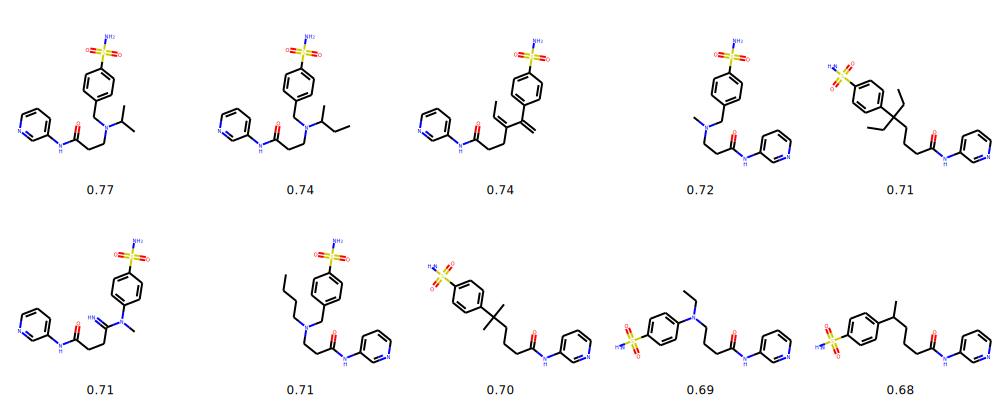

In [33]:
# Best by SC_RDKit Fragments
best_mols = sorted(list(zip(names_frags, best_scores_frags)), key=lambda x: x[1], reverse=True)[:10]

mols = [Chem.MolFromSmiles(m[0]) for m in best_mols]
p = Chem.MolFromSmiles(frag_2_smi)
AllChem.Compute2DCoords(p)

for m in mols: AllChem.GenerateDepictionMatching2DStructure(m,p)
Draw.MolsToGridImage(mols,
                     molsPerRow=5, legends=["%.2f" % m[1] for m in best_mols]
                    )

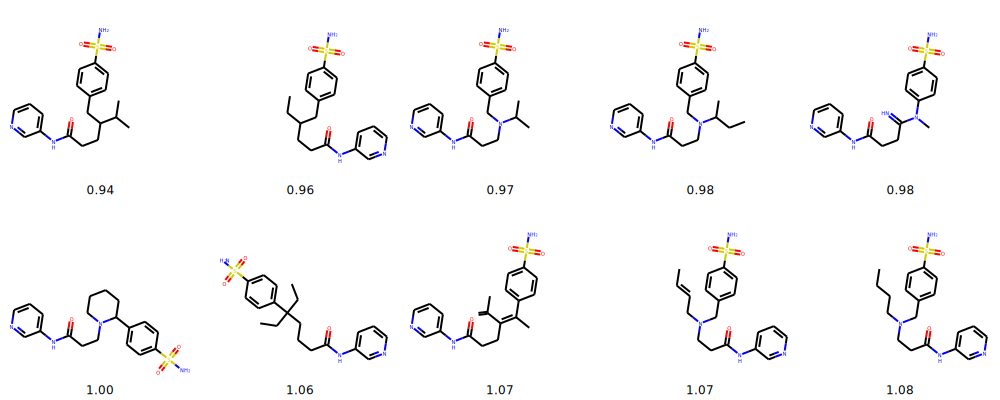

In [34]:
# Best by RMSD Fragments
best_mols = sorted(list(zip(names_rmsd_frags, best_rmsd_frags)), key=lambda x: x[1])[:10]

mols = [Chem.MolFromSmiles(m[0]) for m in best_mols]
p = Chem.MolFromSmiles(frag_2_smi)
AllChem.Compute2DCoords(p)

for m in mols: AllChem.GenerateDepictionMatching2DStructure(m,p)
Draw.MolsToGridImage(mols,
                     molsPerRow=5, legends=["%.2f" % m[1] for m in best_mols]
                    )